In [1]:
import torch 
from cross_attention import AttentionStore, show_cross_attention, run_and_display, AttentionReplace, LocalBlend , AttentionRefine, get_equalizer, AttentionReweight
import utils
from diffusers import StableDiffusionPipeline, DDIMScheduler
from absl_mock import Mock_Flag 
from config import read_cfg

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

read_cfg()
flags = Mock_Flag() 
FLAGS = flags.FLAGS

#Init diffusion model
SD_Model = FLAGS.sd_model
model_path= FLAGS.store_path
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
ldm_stable = StableDiffusionPipeline.from_pretrained(SD_Model, cache_dir=model_path, scheduler=scheduler, torch_dtype=torch.float16 ).to(device)#scheduler= scheduler,
tokenizer = ldm_stable.tokenizer
MAX_NUM_WORDS = tokenizer.model_max_length
LOW_RESOURCE= FLAGS.low_resource
NUM_DIFFUSION_STEPS= FLAGS.num_diffusion_steps
GUIDANCE_SCALE= FLAGS.guidance_scale
print("Loaded all models to GPU")
from PIL import Image
generator= torch.cuda.manual_seed(798122)
input_image = Image.open("./portrait.jpg")
input_image=input_image.resize((512, 512))

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

/anaconda/envs/solo_learn/lib/python3.10/site-packages/diffusers/utils/deprecation_utils.py:35: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.9.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "steps_offset": 0,
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config accordingly as leaving `steps_offset` might led to incorrect results in future versions. If you have downloaded this checkpoint from the Hugging Face Hub, it would be very nice if you could open a Pull request for the `scheduler/scheduler_config.json` file
  warnings.warn(warning + message, FutureWarning)


Loaded all models to GPU


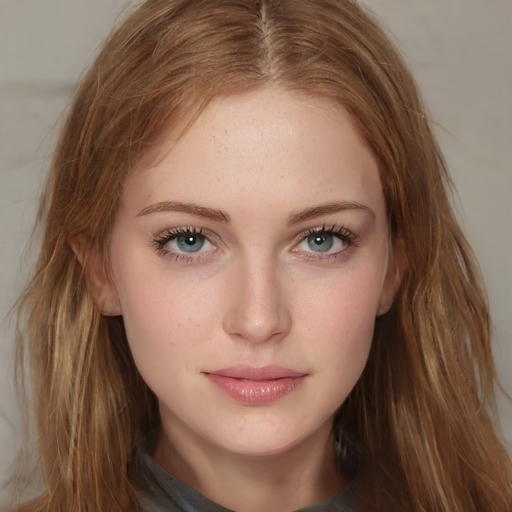

In [3]:
input_image

In [8]:
## Prompt form CLIP interrogator 
#prompt="a woman with long red hair and bimport lovely_tensors as ltlue eyes, a computer rendering, photorealism, gorgeous female samara weaving, ana de armas as joan of arc, clean perfect symmetrical face, short blonde afro, redshift renderer, average human face, mid 2 0's female, an ai generated image"
prompt= "a photo of a woman with blonde hair"
prompts=["a photo of a woman with blonde hair", "a photo of a woman with black hair"]
init_latent= utils.inversestablediffusion(ldm_stable,init_image=input_image, prompt=prompt, refine_iterations=5, guidance_scale=4.0)
# init_latent=utils.init_image_to_latent(ldm_stable, prompt,input_image )

  0%|          | 0/50 [00:00<?, ?it/s]

In [7]:
# import numpy as np
# import torchvision.transforms as T
# ## Convert Latent back to Image 
# latents = 1 / 0.18215 * init_latent
# with torch.autocast("cuda"), torch.inference_mode(): 
#     image = ldm_stable.vae.decode(latents)['sample']
# image = (image / 2 + 0.5).clamp(0, 1)
# image = image.cpu().permute(0, 2, 3, 1).numpy()
# image = (image * 255).astype(np.uint8)

# print(image.shape)
# transform = T.ToPILImage()
# img = transform(image[0])
# img

  0%|          | 0/1000 [00:00<?, ?it/s]

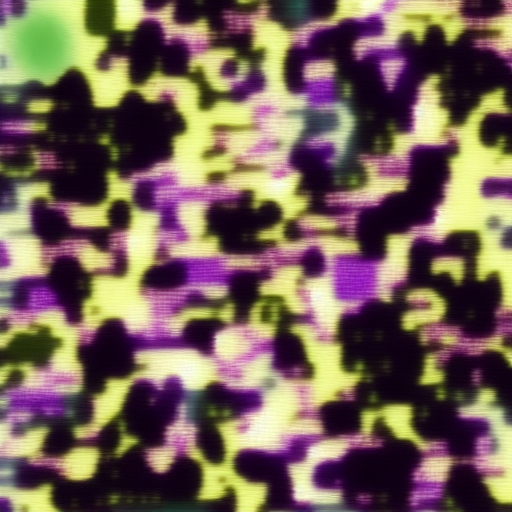

In [9]:
utils.stablediffusion(ldm_stable,"a photo of a woman with blonde hair", guidance_scale=4.0, init_latents=init_latent)


In [13]:
import requests
from PIL import Image
from io import BytesIO
import torch
import os
from diffusers import DiffusionPipeline, DDIMScheduler
has_cuda = torch.cuda.is_available()
device = torch.device('cpu' if not has_cuda else 'cuda')
pipe = DiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    cache_dir=model_path,
    
    custom_pipeline="imagic_stable_diffusion",
    scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
).to(device)
generator = torch.cuda.manual_seed(798122)
seed = 0
prompt = "A photo of Barack Obama smiling with a big grin"
url = 'https://www.dropbox.com/s/6tlwzr73jd1r9yk/obama.png?dl=1'
response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")
init_image = init_image.resize((512, 512))
res = pipe.train(
    prompt,
    image=init_image,
    generator=generator)
res = pipe(alpha=1)

os.makedirs("imagic", exist_ok=True)
image = res.images[0]
image.save('./imagic/imagic_image_alpha_1.png')
res = pipe(alpha=1.5)
image = res.images[0]
image.save('./imagic/imagic_image_alpha_1_5.png')
res = pipe(alpha=2)
image = res.images[0]
image.save('./imagic/imagic_image_alpha_2.png')

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Keyword arguments {'truncaton': True} not recognized.


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


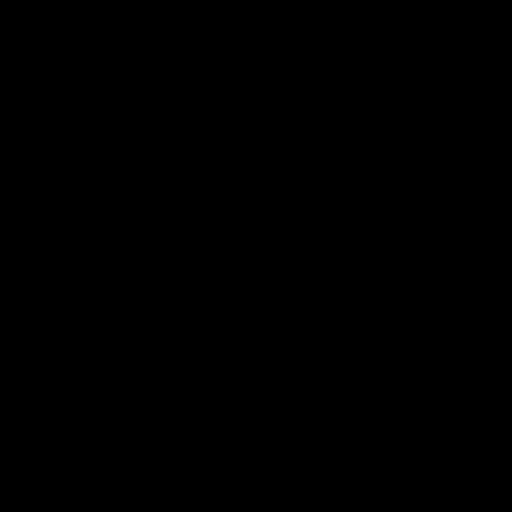

In [14]:
image